Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [392]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential

from glob import glob

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import Adam

In [322]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [323]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

data_dir_train = pathlib.Path("/Users/rajendrakumar.sharma/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/train")
data_dir_test = pathlib.Path("/Users/rajendrakumar.sharma/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/test")

# data_dir_train = pathlib.Path("/Users/rajendrakumar.sharma/Desktop/upgrad/CNNAssignment/Skin cancer ISIC The International Skin Imaging Collaboration/train")
# data_dir_test = pathlib.Path('/Users/rajendrakumar.sharma/Desktop/upgrad/CNNAssignment/Skin cancer ISIC The International Skin Imaging Collaboration/test')

In [164]:
# print(data_dir_train, '\n', data_dir_test)

In [324]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [325]:
batch_size = 32
img_height = 180
img_width = 180
num_classes = 9

Use 80% of the images for training, and 20% for validation.

In [326]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = image_dataset_from_directory(data_dir_train, labels='inferred', batch_size=batch_size, 
                                        image_size = (img_height, img_width), seed=123, validation_split = 0.2, subset='training', shuffle=True)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [327]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
# val_ds = #todo

val_ds = image_dataset_from_directory(data_dir_train, labels='inferred', batch_size=batch_size, 
                                        image_size = (img_height, img_width), seed=123, validation_split = 0.2, subset='validation', shuffle=True)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [328]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
# print(class_names)

class_name_map = {i:j for i , j in   enumerate(class_names)}

print(class_name_map)


{0: 'actinic keratosis', 1: 'basal cell carcinoma', 2: 'dermatofibroma', 3: 'melanoma', 4: 'nevus', 5: 'pigmented benign keratosis', 6: 'seborrheic keratosis', 7: 'squamous cell carcinoma', 8: 'vascular lesion'}


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

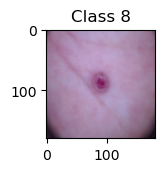

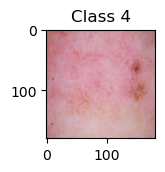

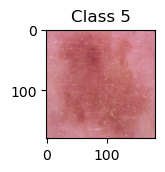

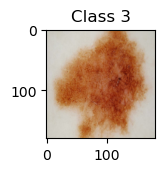

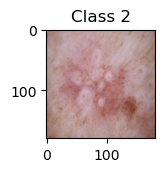

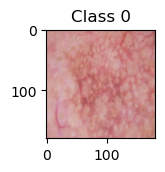

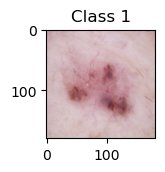

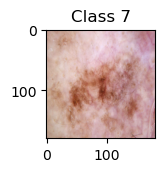

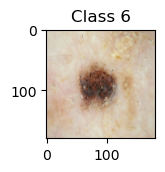

In [329]:
import numpy as np
import matplotlib.pyplot as plt


class_images = {}


for batch in train_ds:
    images, labels = batch  # Get a batch of images and labels

    # Iterate through images and labels in the batch
    for img, label in zip(images, labels):
        class_no = int(label.numpy())  # Convert the label to an integer
        
        # Only store an image for the class if it's not already stored
        if class_no not in class_images:
            class_images[class_no] = img.numpy()  # Store the image as a numpy array
        
        # If we've stored one image for every class, break the loop
        if len(class_images) == num_classes:
            break
    if len(class_images) == num_classes:
        break

i=0
for class_no, img in class_images.items():
    plt.subplot(3, 3, i + 1)
    img=np.clip(img,0, 255).astype(np.uint8)
    plt.imshow(img)  # Assuming grayscale images, adjust for RGB
    plt.title(f"Class {class_no}")
    plt.show()
    i+=1


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [330]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [331]:
image, label = next(iter(train_ds))
input_shape = image.shape[1:]

print(input_shape)

(180, 180, 3)


### Create the model : Model 1


In [332]:
### Model 1 : Conv(32,64,128) : Relu, Flatten(), Output:Softmax



model = keras.Sequential(

[

layers.Rescaling(scale=1./255, input_shape = input_shape),
    

layers.Conv2D(32, kernel_size = (3,3), padding = 'same', strides=1, activation='relu'),
layers.MaxPool2D((2,2)),


layers.Conv2D(64, kernel_size = (3,3), padding = 'same', strides=1, activation='relu'),
layers.MaxPool2D((2,2)),


layers.Conv2D(128, kernel_size = (3,3), padding = 'same', strides=1, activation='relu'),
layers.MaxPool2D((2,2)),

# --------------------------FC

layers.Flatten(),

layers.Dense(num_classes, 'softmax')
    
]
    
)


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [333]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [334]:
# View the summary of all layers
model.summary()

Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_40 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_118 (Conv2D)             │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_117               │ (None, 90, 90, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_119 (Conv2D)             │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_118               │ (None, 45, 45, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_120 (Conv2D)             │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_119               │ (None, 22, 22, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_37 (Flatten)            │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 9)              │       557,577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 650,825 (2.48 MB)

 Trainable params: 650,825 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [335]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 242ms/step - accuracy: 0.2283 - loss: 2.0185 - val_accuracy: 0.4810 - val_loss: 1.5857
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 228ms/step - accuracy: 0.4595 - loss: 1.5382 - val_accuracy: 0.4855 - val_loss: 1.4656
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 228ms/step - accuracy: 0.4881 - loss: 1.4285 - val_accuracy: 0.4944 - val_loss: 1.5620
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 230ms/step - accuracy: 0.5157 - loss: 1.3982 - val_accuracy: 0.5034 - val_loss: 1.4541
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 234ms/step - accuracy: 0.5822 - loss: 1.2214 - val_accuracy: 0.4966 - val_loss: 1.4404
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 234ms/step - accuracy: 0.5929 - loss: 1.1654 - val_accuracy: 0.5481 - val_loss: 1.4054
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 232ms/step - accuracy: 0.6575 - loss: 1.0099 - val_accuracy: 0.5011 - val_loss: 1.4801
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 234ms/step - accuracy: 0.6440 - loss: 1.0305 - val_accu

### Visualizing training results

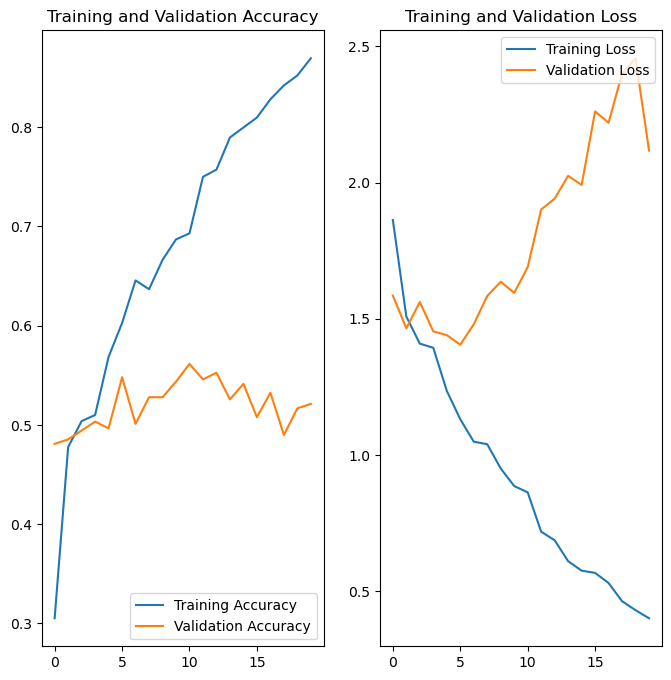

In [336]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

1. Overfitting Evidence: The model shows high training accuracy, nearing 88%,
    while validation accuracy remains low and fluctuating, indicating overfitting.
    This suggests that the model is performing well on the training data but struggles to generalize to unseen data.


2. Increasing Validation Loss: The validation loss graph shows an upward trend over the epochs, 
    confirming that the model's performance on validation data deteriorates over time, another sign of overfitting.


3. Balanced Network Design: The CNN model follows a standard architecture with three convolutional layers,
    each followed by max-pooling layers. 
    The use of ReLU activation and softmax output ensures effective feature extraction and classification.


4. Potential Improvements: To address overfitting, techniques such as dropout, data augmentation, 
        or reducing the model's complexity (fewer filters or layers) could be employed. 
        Early stopping based on validation loss could also prevent further overfitting.

### Create the model : Model 2
#### # Reduce the model complexity and add the dropout to handle the overfititing 

In [342]:
model = keras.Sequential(

[

layers.Rescaling(scale=1./255, input_shape = input_shape),
    

layers.Conv2D(32, kernel_size = (3,3), padding = 'same', strides=1, activation='relu'),
layers.MaxPool2D((2,2)),
layers.Dropout(0.2),


layers.Conv2D(32, kernel_size = (3,3), padding = 'same', strides=1, activation='relu'),
layers.MaxPool2D((2,2)),
layers.Dropout(0.2),


layers.Conv2D(32, kernel_size = (3,3), padding = 'same', strides=1, activation='relu'),
layers.MaxPool2D((2,2)),
layers.Dropout(0.2),

# --------------------------FC

layers.Flatten(),
layers.Dropout(0.3),

layers.Dense(num_classes, 'softmax')
    
]
    
)


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [343]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [344]:
# View the summary of all layers
model.summary()

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_42 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_122 (Conv2D)             │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_121               │ (None, 90, 90, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_123 (Conv2D)             │ (None, 90, 90, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_122               │ (None, 45, 45, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_124 (Conv2D)             │ (None, 45, 45, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_123               │ (None, 22, 22, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_38 (Flatten)            │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 9)              │       139,401 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,793 (620.29 KB)

 Trainable params: 158,793 (620.29 KB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [345]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - accuracy: 0.1821 - loss: 2.2059 - val_accuracy: 0.2752 - val_loss: 2.0273
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.2540 - loss: 1.9770 - val_accuracy: 0.3154 - val_loss: 1.9057
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 0.3585 - loss: 1.7949 - val_accuracy: 0.3960 - val_loss: 1.6784
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.4337 - loss: 1.5854 - val_accuracy: 0.4273 - val_loss: 1.6216
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.4467 - loss: 1.5351 - val_accuracy: 0.4183 - val_loss: 1.6763
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.4527 - loss: 1.5139 - val_accuracy: 0.4452 - val_loss: 1.5761
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.4964 - loss: 1.4680 - val_accuracy: 0.4966 - val_loss: 1.4859
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 0.5113 - loss: 1.4108 - val_accuracy: 0

### Visualizing training results

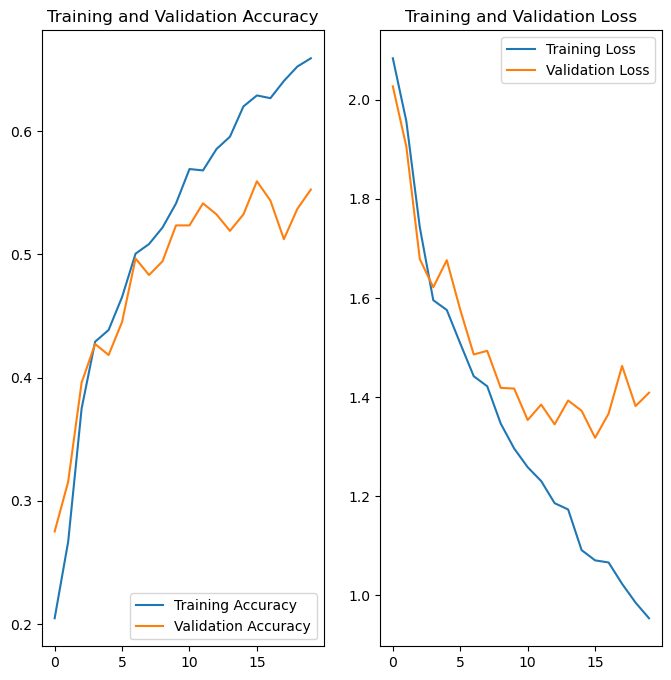

In [346]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

1. Model Complexity Reduction: Reducing the number of filters in each convolutional layer (from 32-64-128 to 32-32-32) 
    helped simplify the model, possibly reducing overfitting. 
    However, this also limited the model’s capacity to learn complex features, resulting in lower accuracy.


2. Dropout Regularization: Adding dropout (0.2 after CNN layers and 0.3 after the fully connected layer) 
    helped prevent overfitting by forcing the network to learn more robust patterns. 
    However, it may have also contributed to slightly reduced training accuracy.


3. Current Accuracy Levels: The model achieved 67% training accuracy and 55% validation accuracy, 
        indicating some level of overfitting persists. The gap suggests the model struggles to generalize well to unseen data.


4. Next Steps: To further improve performance, consider: Increase model complexity 
    Increasing the dataset size (through data augmentation).
    Fine-tuning hyperparameters, dropout rates


In [347]:
images, labels = next(iter(train_ds))
smpl_image = images[0]/255
smpl_label = labels[0]
print(smpl_image)

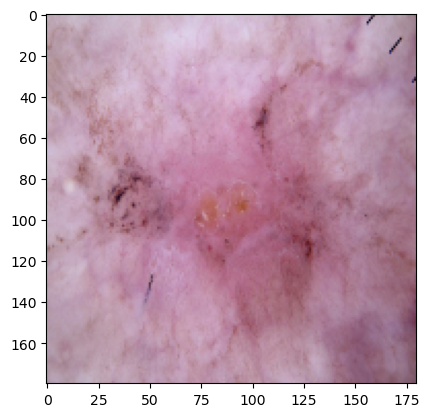

In [348]:
plt.imshow(smpl_image)

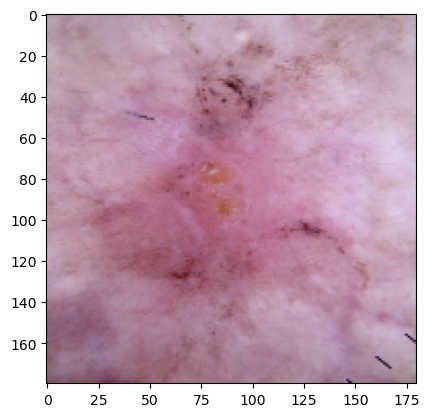

In [349]:
# check the augmentation on sinle image

tf.seed=123

def augmentation(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image)
    img_aug_rb = tf.image.random_brightness(image,  0.2)

    return image

img_aug = augmentation(smpl_image)
plt.imshow(img_aug)




#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
    Class seborrheic keratosis have least sample 3.4% of total samples. 
#### - Which classes dominate the data in terms proportionate number of samples?
    Class melanoma dominates data with 20% of samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [369]:
path_to_training_dataset=data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset) + '/'+ i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /Users/rajendrakumar.sharma/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x36E9AA750>: 100%|█|


Initialised with 376 image(s) found.
Output directory set to /Users/rajendrakumar.sharma/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1342A57F0>: 100%|█|


Initialised with 95 image(s) found.
Output directory set to /Users/rajendrakumar.sharma/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x3


Initialised with 438 image(s) found.
Output directory set to /Users/rajendrakumar.sharma/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x36E4E66F0>: 100%|█


Initialised with 357 image(s) found.
Output directory set to /Users/rajendrakumar.sharma/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x373CFB080>: 100%|█|


Initialised with 462 image(s) found.
Output directory set to /Users/rajendrakumar.sharma/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x36B10F7A0>: 100%|█|


Initialised with 77 image(s) found.
Output directory set to /Users/rajendrakumar.sharma/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x338737710>: 100%|█


Initialised with 181 image(s) found.
Output directory set to /Users/rajendrakumar.sharma/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x36BD9FC50>: 100%|█|


Initialised with 139 image(s) found.
Output directory set to /Users/rajendrakumar.sharma/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x36835DFD0>: 100%|█|


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [370]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [371]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# path_list

In [372]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# lesion_list_new

In [373]:
class_counter = Counter()
for path in path_list:
    class_label = os.path.basename(os.path.dirname(os.path.dirname(path)))
    class_counter[class_label]+=1
print(class_counter)


Counter({'melanoma': 500, 'pigmented benign keratosis': 500, 'nevus': 500, 'basal cell carcinoma': 500, 'actinic keratosis': 500, 'squamous cell carcinoma': 500, 'vascular lesion': 500, 'seborrheic keratosis': 500, 'dermatofibroma': 500})


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [374]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [375]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size,
 shuffle=True)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [376]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size,
 shuffle=True)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [377]:
# check validaton class distriubtion 
class_counter = Counter()

# Iterate through the validation dataset
for _, labels in val_ds.as_numpy_iterator():
    class_counter.update(labels)  # For one-hot encoded labels

# Convert the counter to a dictionary for easier reading

class_distribution = dict(class_counter)
print("Class distribution in validation dataset:", class_distribution)

Class distribution in validation dataset: {0: 121, 7: 112, 1: 155, 8: 146, 3: 183, 2: 140, 5: 189, 4: 180, 6: 121}


#### Model 3: After data Augmentation

In [378]:
model = keras.Sequential(
[

layers.Rescaling(scale=1./255, input_shape = input_shape),

layers.Conv2D(32, kernel_size = (3,3), padding = 'same', strides=1, activation='relu'),
# layers.BatchNormalization(),
layers.MaxPool2D((2,2)),
layers.Dropout(0.2),
    

layers.Conv2D(64, kernel_size = (3,3), padding = 'same', strides=1, activation='relu'),
# layers.BatchNormalization(),
layers.MaxPool2D((2,2)),
layers.Dropout(0.2),


layers.Conv2D(128, kernel_size = (3,3), padding = 'same', strides=1, activation='relu'),
# layers.BatchNormalization(),
layers.MaxPool2D((2,2)),
layers.Dropout(0.5),


# layers.Conv2D(256, kernel_size = (3,3), padding = 'same', strides=1, activation='relu'),
# layers.MaxPool2D((2,2)),


layers.Flatten(),
# layers.GlobalAveragePooling2D(),


layers.Dense(128, activation='relu'),
# layers.BatchNormalization(),
layers.Dropout(0.25),
layers.Dense(num_classes, 'softmax')
    ]
)




#### Compile 

In [379]:
## your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [380]:
model.summary()

Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_48 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_140 (Conv2D)             │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_139               │ (None, 90, 90, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_107 (Dropout)           │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_141 (Conv2D)             │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_140               │ (None, 45, 45, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_108 (Dropout)           │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_142 (Conv2D)             │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_141               │ (None, 22, 22, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_109 (Dropout)           │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_44 (Flatten)            │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_110 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

#### Train your model

In [381]:
# epochs = 30
## Your code goes here, use 50 epochs.
# history = # your model fit code
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 252ms/step - accuracy: 0.1729 - loss: 2.2933 - val_accuracy: 0.3452 - val_loss: 1.7334
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 250ms/step - accuracy: 0.3360 - loss: 1.7162 - val_accuracy: 0.4209 - val_loss: 1.5331
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 249ms/step - accuracy: 0.4437 - loss: 1.4783 - val_accuracy: 0.5278 - val_loss: 1.3403
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 251ms/step - accuracy: 0.4928 - loss: 1.3558 - val_accuracy: 0.5427 - val_loss: 1.3154
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 251ms/step - accuracy: 0.5206 - loss: 1.2689 - val_accuracy: 0.5085 - val_loss: 1.3155
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 251ms/step - accuracy: 0.5470 - loss: 1.1890 - val_accuracy: 0.6021 - val_loss: 1.1120
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 252ms/step - accuracy: 0.5732 - loss: 1.1131 - val_accuracy: 0.6236 - val_loss: 1.0469
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 252ms/step - accuracy: 0.6228 - loss: 1

#### **Todo:**  Visualize the model results

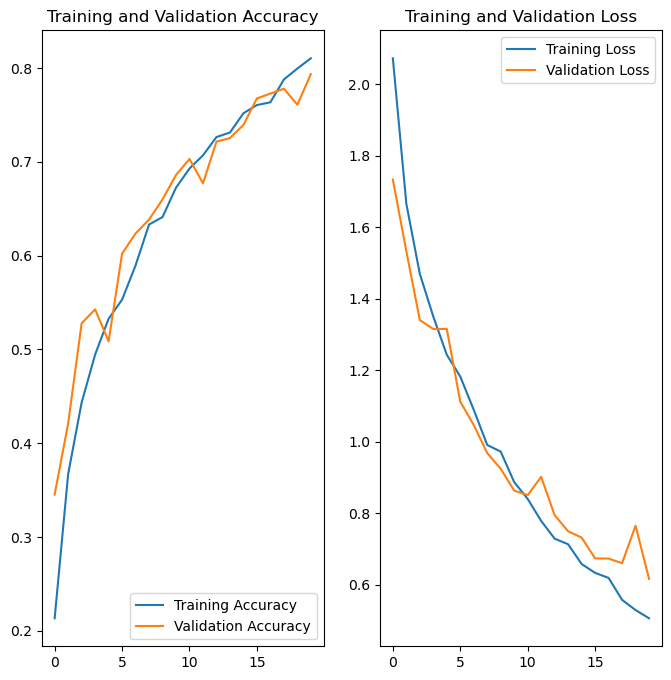

In [382]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Findings:**  



1. Model Performance:

Training Accuracy: 80%
Test (Validation) Accuracy: 79%
The minimal gap between training and test accuracy indicates good generalization—your model is not overfitting.



2. Effect of Dropout:

Dropout values of 0.2, 0.2, 0.5, and 0.25 are working well.
Dropout prevented overfitting while maintaining model capacity to learn complex features.



3. Improved Architecture:

Increasing the number of filters across layers (32 → 64 → 128) helped the model learn more complex patterns.
Dense layer with 128 units provided additional learning capacity to capture non-linear relationships.



4. Balanced Training:

Both training and test accuracies are close, indicating the model is well-tuned for this dataset.
The dropout values are appropriate: higher in dense layers (0.5) where overfitting is more common.

#### Model 4: Add batch normalization

In [383]:
model = keras.Sequential(
[

layers.Rescaling(scale=1./255, input_shape = input_shape),

layers.Conv2D(32, kernel_size = (3,3), padding = 'same', strides=1, activation='relu'),
layers.BatchNormalization(),
layers.MaxPool2D((2,2)),
layers.Dropout(0.2),
    

layers.Conv2D(64, kernel_size = (3,3), padding = 'same', strides=1, activation='relu'),
layers.BatchNormalization(),
layers.MaxPool2D((2,2)),
layers.Dropout(0.2),


layers.Conv2D(128, kernel_size = (3,3), padding = 'same', strides=1, activation='relu'),
layers.BatchNormalization(),
layers.MaxPool2D((2,2)),
layers.Dropout(0.5),


# layers.Conv2D(256, kernel_size = (3,3), padding = 'same', strides=1, activation='relu'),
# layers.MaxPool2D((2,2)),


layers.Flatten(),
# layers.GlobalAveragePooling2D(),


layers.Dense(128, activation='relu'),
layers.BatchNormalization(),
layers.Dropout(0.25),
layers.Dense(num_classes, 'softmax')
    ]
)




#### Compile

In [384]:
## your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [385]:
model.summary()

Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_49 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_143 (Conv2D)             │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_142               │ (None, 90, 90, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_144 (Conv2D)             │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_143               │ (None, 45, 45, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_112 (Dropout)           │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_145 (Conv2D)             │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 45, 45, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_144               │ (None, 22, 22, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_45 (Flatten)            │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_114 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,025,801 (30.62 MB)

 Trainable params: 8,025,097 (30.61 MB)

 Non-trainable params: 704 (2.75 KB)

#### **Todo:**  Train your model

In [386]:
# epochs = 30
## Your code goes here, use 50 epochs.
# history = # your model fit code
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 78s 449ms/step - accuracy: 0.3521 - loss: 1.9894 - val_accuracy: 0.0898 - val_loss: 17.5818
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 77s 453ms/step - accuracy: 0.5279 - loss: 1.2896 - val_accuracy: 0.1722 - val_loss: 3.0048
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 76s 450ms/step - accuracy: 0.6347 - loss: 1.0302 - val_accuracy: 0.4967 - val_loss: 1.3515
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 75s 446ms/step - accuracy: 0.6984 - loss: 0.8438 - val_accuracy: 0.3437 - val_loss: 1.8768
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 76s 447ms/step - accuracy: 0.7712 - loss: 0.6548 - val_accuracy: 0.6347 - val_loss: 0.9855
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 76s 447ms/step - accuracy: 0.8161 - loss: 0.5235 - val_accuracy: 0.6281 - val_loss: 1.0848
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 487ms/step - accuracy: 0.8281 - loss: 0.4536 - val_accuracy: 0.6889 - val_loss: 0.8576
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 475ms/step - accuracy: 0.8813 - loss: 

#### **Todo:**  Visualize the model results

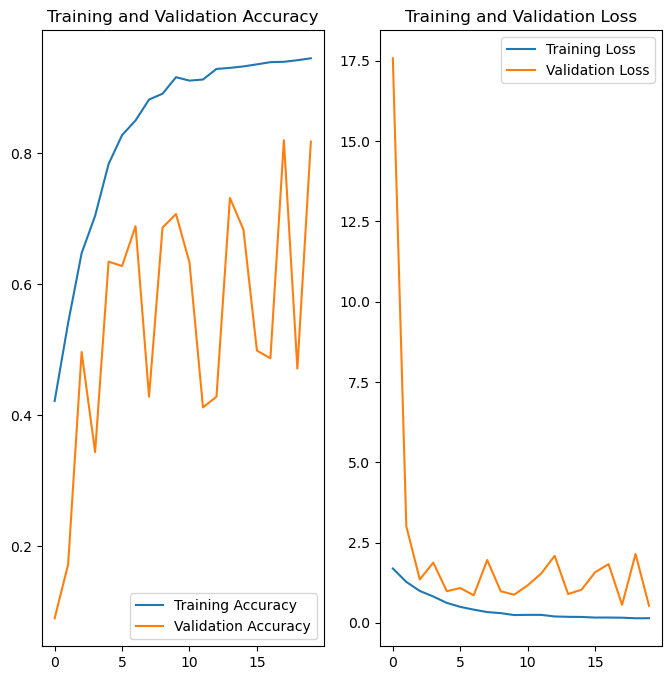

In [388]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Findings:**  



#### Model 5: TUNE LEANRING RATE

In [399]:
model = keras.Sequential(
[

layers.Rescaling(scale=1./255, input_shape = input_shape),

layers.Conv2D(32, kernel_size = (3,3), padding = 'same', strides=1, activation='relu'),
layers.BatchNormalization(),
layers.MaxPool2D((2,2)),
layers.Dropout(0.2),
    

layers.Conv2D(64, kernel_size = (3,3), padding = 'same', strides=1, activation='relu'),
layers.BatchNormalization(),
layers.MaxPool2D((2,2)),
layers.Dropout(0.2),


layers.Conv2D(128, kernel_size = (3,3), padding = 'same', strides=1, activation='relu'),
layers.BatchNormalization(),
layers.MaxPool2D((2,2)),
layers.Dropout(0.5),


# layers.Conv2D(256, kernel_size = (3,3), padding = 'same', strides=1, activation='relu'),
# layers.MaxPool2D((2,2)),


layers.Flatten(),
# layers.GlobalAveragePooling2D(),


layers.Dense(128, activation='relu'),
layers.BatchNormalization(),
layers.Dropout(0.25),
layers.Dense(num_classes, 'softmax')
    ]
)




#### Compile

In [400]:
## your code goes here
optimizer = Adam(learning_rate=0.0002)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [401]:
model.summary()

Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_51 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_149 (Conv2D)             │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_148               │ (None, 90, 90, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_119 (Dropout)           │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_150 (Conv2D)             │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_149               │ (None, 45, 45, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_120 (Dropout)           │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_151 (Conv2D)             │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 45, 45, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_150               │ (None, 22, 22, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_121 (Dropout)           │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_47 (Flatten)            │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_122 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,025,801 (30.62 MB)

 Trainable params: 8,025,097 (30.61 MB)

 Non-trainable params: 704 (2.75 KB)

#### **Todo:**  Train your model

In [402]:
# epochs = 30

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 73s 426ms/step - accuracy: 0.3606 - loss: 1.9214 - val_accuracy: 0.0898 - val_loss: 8.0113
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 73s 430ms/step - accuracy: 0.5612 - loss: 1.2292 - val_accuracy: 0.1448 - val_loss: 6.7075
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 74s 440ms/step - accuracy: 0.6222 - loss: 1.0631 - val_accuracy: 0.2665 - val_loss: 4.0546
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 73s 430ms/step - accuracy: 0.6902 - loss: 0.8926 - val_accuracy: 0.4417 - val_loss: 1.7763
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 73s 430ms/step - accuracy: 0.7510 - loss: 0.7268 - val_accuracy: 0.6652 - val_loss: 1.0604
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 75s 443ms/step - accuracy: 0.7864 - loss: 0.6343 - val_accuracy: 0.6459 - val_loss: 1.1157
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 72s 426ms/step - accuracy: 0.8123 - loss: 0.5497 - val_accuracy: 0.5093 - val_loss: 3.0758
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 74s 438ms/step - accuracy: 0.8160 - loss: 0

#### **Todo:**  Visualize the model results

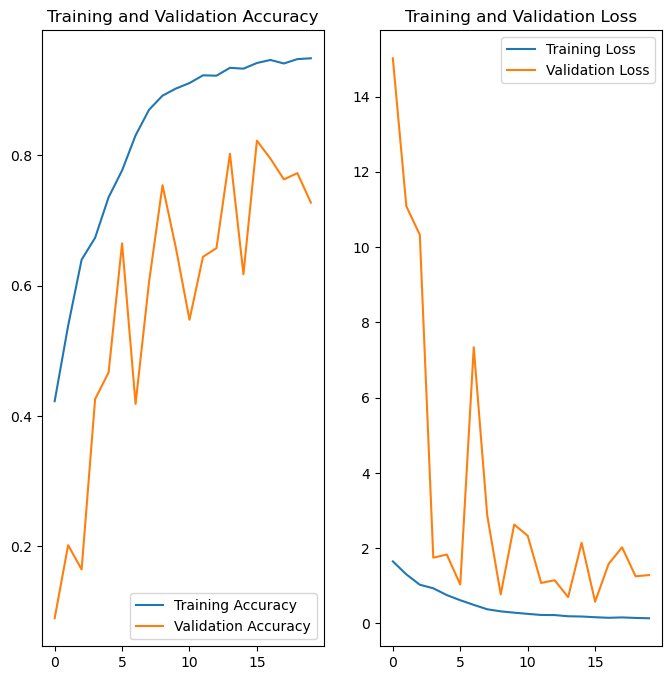

In [398]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Findings:**  



1. Training Accuracy Spike:

The training accuracy jumped to 94%, which indicates that the model is learning very well on the training data.

However, this may also point towards potential overfitting as the training accuracy is significantly higher than the validation accuracy.



2. Validation Accuracy Instability:

The validation accuracy oscillates wildly between 42% and 81%, showing instability. In one epoch, it goes as high as 73%, and in the next, it drops as low as 46%.

This large variance is likely due to a learning rate that's too high or too aggressive optimization, causing the model to jump around the loss landscape instead of converging smoothly.

3. Batch Normalization Effect:

Batch normalization helps with faster convergence by normalizing activations across layers. It also acts as a regularizer but could lead to instability in certain settings if not tuned carefully.

In [403]:
# Final Model
model = keras.Sequential(
[

layers.Rescaling(scale=1./255, input_shape = input_shape),

layers.Conv2D(32, kernel_size = (3,3), padding = 'same', strides=1, activation='relu'),
# layers.BatchNormalization(),
layers.MaxPool2D((2,2)),
layers.Dropout(0.2),
    

layers.Conv2D(64, kernel_size = (3,3), padding = 'same', strides=1, activation='relu'),
# layers.BatchNormalization(),
layers.MaxPool2D((2,2)),
layers.Dropout(0.2),


layers.Conv2D(128, kernel_size = (3,3), padding = 'same', strides=1, activation='relu'),
# layers.BatchNormalization(),
layers.MaxPool2D((2,2)),
layers.Dropout(0.5),


# layers.Conv2D(256, kernel_size = (3,3), padding = 'same', strides=1, activation='relu'),
# layers.MaxPool2D((2,2)),


layers.Flatten(),
# layers.GlobalAveragePooling2D(),


layers.Dense(128, activation='relu'),
# layers.BatchNormalization(),
layers.Dropout(0.25),
layers.Dense(num_classes, 'softmax')
    ]
)




In [407]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [408]:
model.summary()

Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_52 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_152 (Conv2D)             │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_151               │ (None, 90, 90, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_123 (Dropout)           │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_153 (Conv2D)             │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_152               │ (None, 45, 45, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_124 (Dropout)           │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_154 (Conv2D)             │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_153               │ (None, 22, 22, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_125 (Dropout)           │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_48 (Flatten)            │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_126 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

In [409]:
epochs = 30

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 262ms/step - accuracy: 0.1237 - loss: 2.6321 - val_accuracy: 0.2019 - val_loss: 2.0355
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 256ms/step - accuracy: 0.2076 - loss: 2.0425 - val_accuracy: 0.2754 - val_loss: 1.8850
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 254ms/step - accuracy: 0.2970 - loss: 1.8332 - val_accuracy: 0.4120 - val_loss: 1.6214
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 260ms/step - accuracy: 0.3902 - loss: 1.6240 - val_accuracy: 0.4543 - val_loss: 1.4890
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 259ms/step - accuracy: 0.4529 - loss: 1.4328 - val_accuracy: 0.5011 - val_loss: 1.3381
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 251ms/step - accuracy: 0.5014 - loss: 1.3302 - val_accuracy: 0.5820 - val_loss: 1.2275
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 251ms/step - accuracy: 0.5462 - loss: 1.2142 - val_accuracy: 0.6065 - val_loss: 1.0815
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 251ms/step - accuracy: 0.5796 - loss: 1

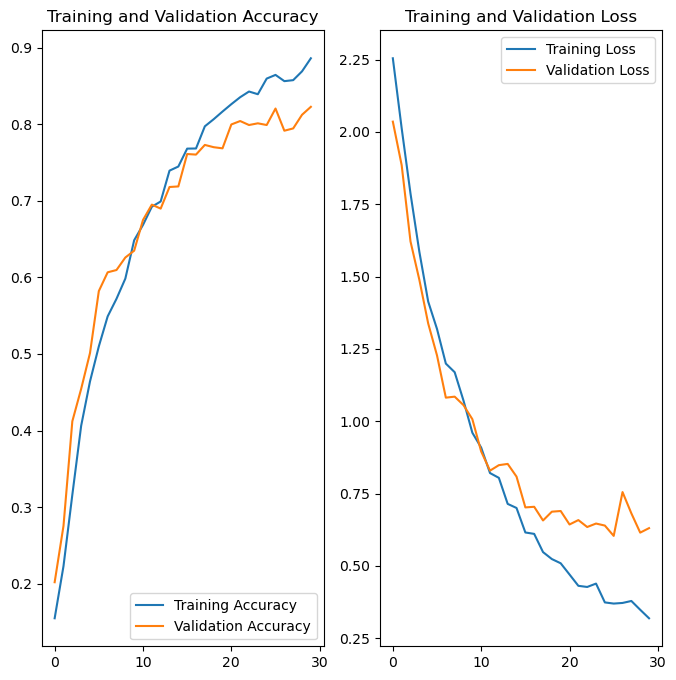

In [410]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1. The final model achieved 85% training accuracy and 80% validation accuracy, indicating that it generalizes 
reasonably well across unseen data. Removing batch normalization simplified the model, 
and with appropriate dropout regularization, the model was able to mitigate overfitting.

2. While the current model performs well, further improvements can be achieved by fine-tuning hyperparameters,
increasing the dataset size, or employing advanced architectures like transfer learning models (e.g., ResNet or InceptionV3).
Future work will also explore additional augmentation strategies to further enhance generalization.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


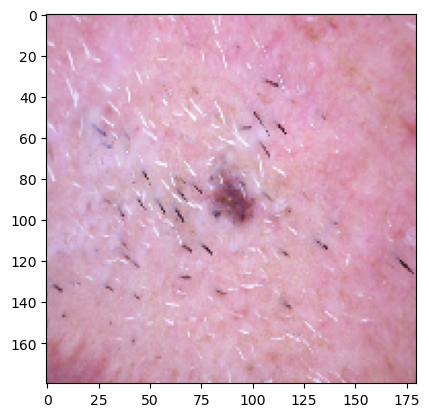

In [411]:
### Model Prediction

from glob import glob
from tensorflow.keras.utils import load_img
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )